#### Какие пункты плана были выполнены, а какие — нет?
### План <br>
    1. Соеденить таблицы по customerID - Успешно
    2. Закодировать все строковые значения - Успешно
    3. Применить метод Upsample - Успешно
    4. Разделить на выборки для обучения - Успешно
    5. Обучить модели - Успешно
### Трудности
    1. В обработке пропусков в данных связи (internet).
### Ключевые шаги.
    1. Чистка и добавление признаков, я добавил признак сколько абонент пользуется услугами оператора и удалил признаки 
    времени, за их не надобностью.
    2. Кодировка данных, я выполнил ее с помощью OrdinalEncoder
    3. Обучение разных моделей классификации.
    

## Лучшая модель и ее качество.
    По ходу обучения я проверил множество моделей(LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, 
    LGBMClassifier, CatBoostClassifier). 
    Лучшее качество показала модель градиентного бустинга LightGBM с roc auc score на тестовой выборке - 0.916046

```
     __________LightGBM__________
                  train      test
f1             0.980762  0.899543
accuracy       0.989966  0.950028
roc auc score  0.981554  0.916046
precision      0.998522  0.963325
recall         0.963623  0.843683

{'learning_rate': 0.1, 'max_depth': 14, 'n_estimators': 126}

```

Так же методом Feature importances выяснил: 
  1. Самые важные признаки влияющие на клиента это время которое он проведет с оператором, размер платежа в месяц и тип платежа.
  2. Самые мало влияющие признаки пожилой ли гражданин, есть ли стриминговое телевидение и является ли абонент иждивенцом.

# Описание и библиотеки

наТаблица <b>contract</b>

- customerID - id пользователя
- BeginDate - дата начала действия
- EndDate - дата окончания действия
- Type - Тип оплаты (раз в год или помесячно)
- PaperlessBilling - безбумажный расчетный лист
- PaymentMethod - тип платежа
- MonthlyCharges - расход за месяц
- TotalCharges - общие расходы

Таблица <b>personal</b>

- customerID - id пользователя
- gender - пол
- SeniorCitizen - пожилой гражданин
- Partner - партнер
- Dependents - иждивенцы

Таблица <b>internet</b>

- customerID - id пользователя
- InternetService - тип подключения
- OnlineSecurity - блокировка небезопасных сайтов
- OnlineBackup - Облачное хранилище файлов для резервного копирования данных
- DeviceProtection - антивирус
- TechSupport - Выделенная линия технической поддержки
- StreamingTV - Стриминговое телевидение
- StreamingMovies - каталог фильмов

Таблица <b>phone</b>

- customerID - id пользователя
- MultipleLines - Подключение телефонного аппарата к нескольким линиям одновременно

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import warnings
import time

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [57]:
warnings.filterwarnings("ignore")

## Подготовка.

In [58]:
try:
    contract = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phone = pd.read_csv('phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [59]:
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [60]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [61]:
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [62]:
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [63]:
full_data = contract.merge(personal, on='customerID', how='left')
full_data = full_data.merge(internet, on='customerID', how='left')
full_data = full_data.merge(phone, on='customerID', how='left')
full_data.columns = full_data.columns.str.lower()

full_data.info()
full_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   seniorcitizen     7043 non-null   int64  
 10  partner           7043 non-null   object 
 11  dependents        7043 non-null   object 
 12  internetservice   5517 non-null   object 
 13  onlinesecurity    5517 non-null   object 
 14  onlinebackup      5517 non-null   object 
 15  deviceprotection  5517 non-null   object 
 16  techsupport       5517 non-null   object 


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Соеденили все таблицы по столбцу customerID.

## Предобработка.

In [64]:
full_data['begindate'] = pd.to_datetime(full_data['begindate'], format='%Y-%m-%d')
full_data['enddate'] = pd.to_datetime(full_data['enddate'], format='%Y-%m-%d', errors='coerce')
full_data['totalcharges'] = pd.to_numeric(full_data['totalcharges'], errors='coerce')

full_data.info()
full_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   seniorcitizen     7043 non-null   int64         
 10  partner           7043 non-null   object        
 11  dependents        7043 non-null   object        
 12  internetservice   5517 non-null   object        
 13  onlinesecurity    5517 non-null   object        
 14  onlinebackup      5517 n

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Перевел totalcharges в тип float.<br>
Перевел begindate и enddate в тип datetime.
<a href='pred'>Предобработка</a>

In [65]:
def work_time(row):
    if not pd.isnull(row['enddate']):
        begin = row['begindate']
        end = row['enddate']
        return (end-begin).days
    
    else:
        begin = row['begindate']
        end = pd.Timestamp(datetime.datetime.strptime('2020-01-02','%Y-%m-%d'))
        return (end-begin).days
    
    
def end_service(row):
    if not pd.isnull(row['enddate']):
        return 1
    else:
        return 0

In [66]:
columns_to_feel = ['internetservice', 'onlinesecurity', 'onlinebackup', 
                   'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

full_data['work_time'] = full_data.apply(work_time, axis=1)
full_data['end_service'] = full_data.apply(end_service, axis=1)

full_data = full_data.drop(['customerid', 'begindate', 'enddate'], axis=1)
full_data[columns_to_feel] = full_data[columns_to_feel].fillna('No')
full_data['totalcharges'] = full_data['totalcharges'].fillna(0)

full_data.info()
full_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              7043 non-null   object 
 1   paperlessbilling  7043 non-null   object 
 2   paymentmethod     7043 non-null   object 
 3   monthlycharges    7043 non-null   float64
 4   totalcharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   seniorcitizen     7043 non-null   int64  
 7   partner           7043 non-null   object 
 8   dependents        7043 non-null   object 
 9   internetservice   7043 non-null   object 
 10  onlinesecurity    7043 non-null   object 
 11  onlinebackup      7043 non-null   object 
 12  deviceprotection  7043 non-null   object 
 13  techsupport       7043 non-null   object 
 14  streamingtv       7043 non-null   object 
 15  streamingmovies   7043 non-null   object 
 16  multiplelines     7043 non-null   object 


,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,work_time,end_service
0,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,1,0
1,One year,No,Mailed check,56.95,1889.50,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1006,0
2,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,61,1
3,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1341,0
4,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,61,1


Вычислил время абонента с оператором и закончил ли он пользоваться услугами оператора ('work_time', 'end_service').<br>
Так же отбросил столбцы customerid, begindate, enddate, дальше они нам не понадобятся.

#### Кодировка данных.

In [67]:
columnsToCode = full_data.drop(['monthlycharges', 'totalcharges', 'work_time', 'end_service', 'seniorcitizen'], axis=1).columns

encoder = OrdinalEncoder()
full_data[columnsToCode] = encoder.fit_transform(full_data[columnsToCode])
full_data[columnsToCode] = full_data[columnsToCode].astype('int')


full_data.info()
full_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              7043 non-null   int32  
 1   paperlessbilling  7043 non-null   int32  
 2   paymentmethod     7043 non-null   int32  
 3   monthlycharges    7043 non-null   float64
 4   totalcharges      7043 non-null   float64
 5   gender            7043 non-null   int32  
 6   seniorcitizen     7043 non-null   int64  
 7   partner           7043 non-null   int32  
 8   dependents        7043 non-null   int32  
 9   internetservice   7043 non-null   int32  
 10  onlinesecurity    7043 non-null   int32  
 11  onlinebackup      7043 non-null   int32  
 12  deviceprotection  7043 non-null   int32  
 13  techsupport       7043 non-null   int32  
 14  streamingtv       7043 non-null   int32  
 15  streamingmovies   7043 non-null   int32  
 16  multiplelines     7043 non-null   int32  


,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,work_time,end_service
0,0,1,2,29.85,29.85,0,0,1,0,0,0,1,0,0,0,0,0,1,0
1,1,0,3,56.95,1889.50,1,0,0,0,0,1,0,1,0,0,0,0,1006,0
2,0,1,3,53.85,108.15,1,0,0,0,0,1,1,0,0,0,0,0,61,1
3,1,0,0,42.30,1840.75,1,0,0,0,0,1,0,1,1,0,0,0,1341,0
4,0,1,2,70.70,151.65,0,0,0,0,1,0,0,0,0,0,0,0,61,1


Перевели все категориальные данные в числовые значения методом OrdinalEncoder.

<AxesSubplot:>

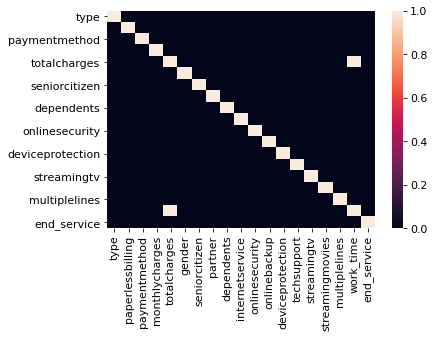

In [68]:
sns.heatmap(full_data.corr() > 0.8)

In [69]:
full_data = full_data.drop('totalcharges', axis=1)

Наблюдается высокая кореляция общей оплаты связи и времени пользованиями услагами опертора, удалим общую оплату за связь, тк её всегда можно вычислить.

In [70]:
full_data

,type,paperlessbilling,paymentmethod,monthlycharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,work_time,end_service
0,0,1,2,29.85,0,0,1,0,0,0,1,0,0,0,0,0,1,0
1,1,0,3,56.95,1,0,0,0,0,1,0,1,0,0,0,0,1006,0
2,0,1,3,53.85,1,0,0,0,0,1,1,0,0,0,0,0,61,1
3,1,0,0,42.30,1,0,0,0,0,1,0,1,1,0,0,0,1341,0
4,0,1,2,70.70,0,0,0,0,1,0,0,0,0,0,0,0,61,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,1,3,84.80,1,0,1,1,0,1,0,1,1,1,1,1,700,0
7039,1,1,1,103.20,0,0,1,1,1,0,1,1,0,1,1,1,2161,0
7040,0,1,2,29.60,0,0,1,1,0,1,0,0,0,0,0,0,307,0
7041,0,1,3,74.40,1,1,1,0,1,0,0,0,0,0,0,1,123,1


#### Деление на выборки.

In [71]:
target = full_data['end_service']
features = full_data.drop('end_service', axis=1)


In [72]:
def class_bar(data, sign):
    df = data.copy()
    df_row = (df[sign].value_counts(normalize = True) * 100).reset_index()
    
    plt.gcf().set_size_inches(16, 5)
    plt.rcParams.update({'font.size': 11})
    sns.barplot(x = 'index', y = sign, data = df_row, edgecolor='.1', saturation = 1)
    for index, row_text in df_row.iterrows():
            plt.text(index, row_text[sign] * 1.01, '{}%'.format(round(row_text[sign], 1)), color = 'black', ha = 'center')
        
    plt.ylim([0, 120])
    plt.grid(axis = 'y')
    plt.xlabel('Класс')
    plt.ylabel('Доля класса')
    plt.title('Диаграмма классового баланса')


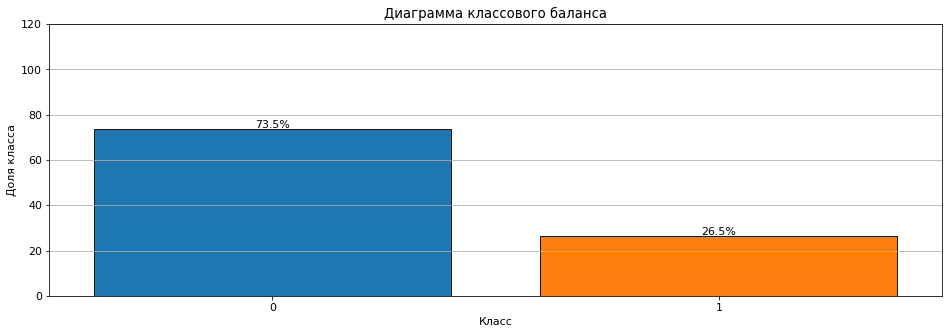

In [73]:
class_bar(full_data, 'end_service')

Классы распределены в отношение 1/3, что неплохо.<br>
Но данных по прежнему мало, так что применим метод upsample.

In [74]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25)
print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(5282, 17) (5282,)
(1761, 17) (1761,)


Разделил данные на обучающую и тестовую выборки в отношение 1/4.

In [75]:
def upsample(features, target, repeat=3):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] * repeat + [features_ones] * (repeat+1))
    target_upsampled = pd.concat([target_zeros] * repeat + [target_ones] * (repeat+1))
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

Функция upsample для увеличения обучающих данных.<br>

## Обучение моделей.

In [76]:
def make_features(features):
    features = features
    target =  full_data['end_service']

    features_train, features_test, target_train, target_test = train_test_split(
                                        features, target, test_size=0.25, random_state=666, stratify=target)
    
    features_train, target_train = upsample(features_train, target_train, 4)
    
    
    return features_train, features_test, target_train, target_test

In [77]:




def learn_model(models, features_train, features_test, target_train, target_test, title=''):
    
    def predict(model, train_predict, target_train, test_predict, target_test):
        
        metrics = {'f1' : f1_score,
                   'accuracy' : accuracy_score,
                   'roc auc score' : roc_auc_score,
                   'precision' : precision_score,
                   'recall' : recall_score
                  }
        columns = ['train', 'test']
        data = []
        for metric in metrics.keys():
            data.append([metrics[metric](target_train, train_predict) ,metrics[metric](target_test, test_predict)])


        results = pd.DataFrame(data=data, index=metrics.keys(), columns=columns)
        
        print(results)
        print()
    
    def fit_model():
        

        plot_data = {}
        learned_model = {}
        
        for model in models.keys():
            print(f'__________{model}__________')
            model_learn = models[model][0]
            params = models[model][1]
            
            start_time = time.time()
            
            grid = GridSearchCV(model_learn, cv=5, param_grid=params, n_jobs=-1)
            grid.fit(features_train, target_train)
            end_time = time.time()
            fit_time = end_time - start_time
            
            plot_data[model] = fit_time # время обучения модели
            learned_model[model] = [grid, grid.best_params_] # сохраняем модель
            
            
            
            train_predict = grid.predict(features_train)
            test_predict = grid.predict(features_test)
            
            predicted = predict(model, train_predict, target_train, test_predict, target_test)
            
            
        sns.barplot(x=list(plot_data.keys()), y=list(plot_data.values()), saturation=1)    
        plt.xlabel('Модели')
        plt.ylabel('Время')
        plt.title(f'Время обучения {title}')
        plt.show()
        
        return learned_model
        
        
    result_model = fit_model()    
    
    
        
    return result_model
            


In [78]:
models = {'Linear' : [LogisticRegression(random_state=666, n_jobs=-1), {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}],
          
          'Forest' : [RandomForestClassifier(random_state=666, n_jobs=-1), {'max_depth':range(1, 8),
                                                                            'min_samples_leaf':range(1,7),
                                                                            'min_samples_split':range (2, 10,2)}],
          
          'Tree': [DecisionTreeClassifier(random_state=666), {'max_depth':range(1, 8),
                                                              'min_samples_leaf':range(1 ,10),
                                                              'min_samples_split':range (2, 10,2)}],
          
          'LightGBM' : [LGBMClassifier(random_state=666, n_jobs=-1), {'learning_rate':[0.001, 0.01, 0.1], 
                                                                     'max_depth':range(1, 15),
                                                                     'n_estimators':range(1, 151, 25)}],
          
          'CatBoost' : [CatBoostClassifier(random_state=666, silent=True, iterations=40), {'learning_rate':[0.001, 0.01, 0.1], 
                                                                          'depth':range(1, 10)}]
         }

In [79]:
features = full_data.drop(['end_service'], axis=1)

features_train, features_test, target_train, target_test = make_features(features)

print(features_train.shape, target_train.shape)
print(features_test.shape, target_test.shape)

(22530, 17) (22530,)
(1761, 17) (1761,)


__________Linear__________
                  train      test
f1             0.629464  0.610459
accuracy       0.778961  0.792731
roc auc score  0.730836  0.735112
precision      0.657854  0.608511
recall         0.603424  0.612420

__________Forest__________
                  train      test
f1             0.723234  0.647856
accuracy       0.840169  0.822828
roc auc score  0.793839  0.756276
precision      0.784036  0.684964
recall         0.671184  0.614561

__________Tree__________
                  train      test
f1             0.727805  0.659815
accuracy       0.830848  0.812039
roc auc score  0.802327  0.772199
precision      0.728794  0.634387
recall         0.726819  0.687366

__________LightGBM__________
                  train      test
f1             0.981528  0.893182
accuracy       0.988682  0.946621
roc auc score  0.982594  0.913043
precision      0.997057  0.951574
recall         0.966476  0.841542

__________CatBoost__________
                  train      test
f1       

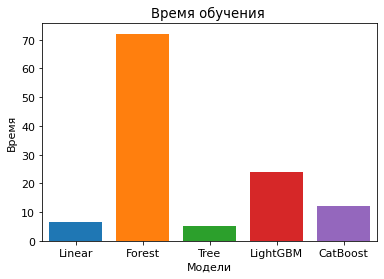

Wall time: 2min


In [80]:
%%time
models = learn_model(models, features_train, features_test, target_train, target_test)

In [81]:
lightgbm = models['LightGBM']
lightgbm

[GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=666), n_jobs=-1,
              param_grid={'learning_rate': [0.001, 0.01, 0.1],
                          'max_depth': range(1, 15),
                          'n_estimators': range(1, 151, 25)}),
 {'learning_rate': 0.1, 'max_depth': 14, 'n_estimators': 126}]

In [82]:
model = LGBMClassifier(learning_rate=0.1, max_depth=9, n_estimators=101)
model.fit(features_train, target_train)

importances = model.feature_importances_

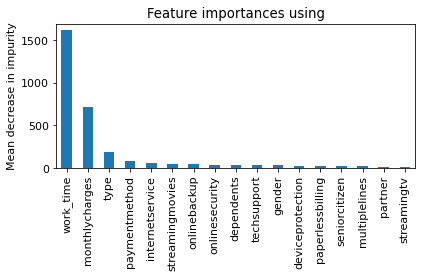

In [83]:
feature_importances = pd.Series(importances, index=full_data.columns[:-1]).sort_values(ascending=False)

fig, ax = plt.subplots()
feature_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Выводы
Выбираем модель градиентного бустинга LightGBM.
  1. Точность предсказаний высока.
  2. Средняя скорость предсказаний между всеми моделями.
  3. Самые важные признаки влияющие на клиента это время которое он проведет с оператором, размер платежа в месяц и тип платежа.
  4. Самые маловлияющие признаки пожилой ли гражданин, есть ли стриминговое телевидение и является ли абонент иждивенцом.